# **REGRESSION MNIST**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
import numpy as np
import random
import seaborn as sns

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv

--2020-12-20 23:01:26--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2020-12-20 23:01:28 (104 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2020-12-20 23:01:28--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regres

# **Network**

In [ ]:
class Net(nn.Module): #NN definition: 3 hidden layers, ReLU activation function
    
    def __init__(self, Ni, Nh1, Nh2, Nh3, No):
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        self.act = nn.ReLU()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.out(x)
        return x

# **Dataset**

In [ ]:
class RegressionDataset(Dataset): #Dataset definition

  def __init__(self, csv_file, transform=None): #initialization of the dataset
    self.transform = transform
    
    with open(csv_file, 'r') as f: #reading of the file
      lines = f.read().split('\n')

    lines.pop(0) #removing of the first line swince it's the title
    self.data = []
    count = 0
    for line in lines:
      count += 1
      sample = line.split(',')
      try:
        self.data.append((float(sample[0]), float(sample[1]))) #check if there are any errors in the file (e. g. spaces)
      except:
        print()

  def __len__(self): #lenght of the dataset
    return len(self.data)

  def __getitem__(self, idx): #Function for retreiving elements. It receives a list of integers as input
    elements = []

    for elem in idx: #For each integer in the input list, retrives the element in that position
      sample = self.data[elem]
      if self.transform:
          sample = self.transform(sample)
      
      elements.append(sample)
    return elements #return list of selected elements

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample): #transforms the samples in a duple of tensors
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [ ]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = RegressionDataset('regression_dataset/train_data.csv', transform=composed_transform) #train dataset
test_dataset = RegressionDataset('regression_dataset/test_data.csv', transform=composed_transform) #test dataset

# **Training**

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #check if GPU is available 
print(f"Training device: {device}")

Training device: cuda


In [ ]:
def initNet(): #function that initializes a new NN
  torch.manual_seed(0)
  Ni = 1 #number of input neurons
  Nh1 = 100 #number of neurons of the first hidden layer
  Nh2 = 200 #number of neurons of the second hidden layer
  Nh3 = 100 #number of neurons of the third hidden layer
  No = 1 #number of output neurons
  net = Net(Ni, Nh1, Nh2, Nh3, No)
  net.to(device)

  return net

In [ ]:
def get_optimizer(n, net, lr): #Function for choosing the optimizer: n = index for the list, net = network model, lr = learning rate
  typeM = [optim.Adagrad(net.parameters(), lr=lr, weight_decay = 1e-3), optim.Adadelta(net.parameters(), lr = lr, weight_decay = 1e-3), optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-3), optim.RMSprop(net.parameters(), lr=lr, weight_decay = 1e-3)]

  return typeM[n]


In [ ]:
###########
#K-Fold Cross Validation
###########

nIter = 3 #number of different set of hyperparameters to try
model_set = {} #best hyperparameters 
loss_fn = nn.MSELoss() #MSE loss function

for i in range(nIter): #for the number of different set
  print('#################')
  print(f'# Iter {i}')
  print('#################')

  kf = KFold(n_splits=5) #5-fold cross validation
  num_epochs = random.randrange(2000, 5000, 20) #number of iteration for training the model
  lr = random.uniform(0, 0.01) #learning rate
  batch_num = [] #batch size
  type_optimizer = random.randrange(0, 4) #type of optimizer (i. e. index in the dictionary for choosing the optimizer)
  
  train_loss_Fold = [] #list for saving the training loss for each fold
  val_loss_Fold = [] #list for saving the validation loss for each fold

  for train_index, val_index in kf.split(train_dataset): #for each fold
    net = initNet()
    optimizer = get_optimizer(type_optimizer, net, lr)
    trainSet, valSet = train_dataset.__getitem__(train_index), train_dataset.__getitem__(val_index) #division in training set and validation set

    if batch_num == []: #check if it's the first iteration
      batch_num = random.randrange(4, len(trainSet) + 1)

    trainSetX = DataLoader(trainSet, batch_size= batch_num, shuffle=True, num_workers=0) #dataloader of the training set
    valSetX = DataLoader(valSet, batch_size=len(valSet), shuffle=True, num_workers=0) #dataloader of the validation set

    train_loss= [] #list for saving the training loss at each epoch
    val_loss= [] #list for saving the validation loss at each epoch

    for epoch_num in range(num_epochs): #for each epoch

      net.train() #training 
      for sample_batched in trainSetX: #for each batch
        x_batch = sample_batched[0].to(device) #input elements
        label_batch = sample_batched[1].to(device) #labels

        out = net(x_batch) #output of the model

        loss = loss_fn(out, label_batch) #loss of the model

        net.zero_grad()
        loss.backward() #backprobagation
        optimizer.step()

        if epoch_num == num_epochs - 1: #saving the loss at the last epoch
          loss_batch = loss.detach().cpu().numpy()
          train_loss.append(loss_batch)

      net.eval() #evaluation
      with torch.no_grad():
        for sample_batched in valSetX: #for each batch
          x_batch = sample_batched[0].to(device) #input elements
          label_batch = sample_batched[1].to(device) #labels

          out = net(x_batch) #output of the model

          loss = loss_fn(out, label_batch) #loss of the model on the evaluation set

          if epoch_num == num_epochs - 1: #saving the loss at the last epoch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
  
    train_loss = np.mean(train_loss) #mean loss of different batches
    train_loss_Fold.append(train_loss)

    val_loss = np.mean(val_loss) #mean loss of different batches
    val_loss_Fold.append(val_loss)

  train_loss = np.mean(train_loss_Fold) #mean of the loss of each fold
  print(f"AVERAGE TRAIN LOSS: {train_loss}")

  val_loss = np.mean(val_loss_Fold) #mean of the loss of each fold
  print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
  val_loss_Fold.append(val_loss)

  if len(model_set) == 0 or val_loss < model_set["loss"]: #save the new best hyperparameter if the new validation losso is lower
    model_set["num_epochs"] = num_epochs
    model_set["lr"] = lr
    model_set["num_batch"] = batch_num
    model_set["type_opt"] = type_optimizer
    model_set["loss"] = val_loss

#################
# Iter 0
#################
Network initialized
Network initialized
Network initialized
Network initialized
Network initialized
AVERAGE TRAIN LOSS: 0.2021183967590332
AVERAGE VAL LOSS: 0.9098862409591675
#################
# Iter 1
#################
Network initialized
Network initialized
Network initialized
Network initialized
Network initialized
AVERAGE TRAIN LOSS: 0.20544925332069397
AVERAGE VAL LOSS: 0.629146933555603
#################
# Iter 2
#################
Network initialized
Network initialized
Network initialized
Network initialized
Network initialized
AVERAGE TRAIN LOSS: 0.2416432648897171
AVERAGE VAL LOSS: 0.7024785280227661


In the next cell you can choose to use whether the hyperparameters that I found to be good or the set of hyperparameters that you found during cross validation

Set 'use_saved' equal to True if you want to use the set that I found

In [ ]:
hyper_set = {} #set of the best hyperparameters
use_saved = True #true if we want to use a set of hyperparameters that is already checked to be very good
                #false if we want to use the new set of hyperparameters given by cross validation
if use_saved:
  hyper_set = {'lr': 0.0015, 'num_batch': 15, 'num_epochs': 1495, 'type_opt': 2}
else:
  hyper_set = {'lr': model_set["lr"], 'num_batch': model_set["num_batch"], 'num_epochs': model_set["num_epochs"], 'type_opt': model_set["type_opt"]}

In [ ]:
num_epochs = hyper_set["num_epochs"] #number of epochs
lr = hyper_set["lr"] #larning rate
batch_num = hyper_set["num_batch"] #size of the batch
type_optimizer = hyper_set["type_opt"] #type of otpimizer

train_loss_log = [] #list of training error at each epoch
test_loss_log = [] #list of validation error at each epoch

train_dataloader = DataLoader(train_dataset.__getitem__(range(len(train_dataset))), batch_size=batch_num, shuffle=True, num_workers=0)

net = initNet() #initialization of the nework
loss_fn = nn.MSELoss() #loss function
optimizer = get_optimizer(type_optimizer, net, lr) #optimizer

for epoch_num in range(num_epochs): #for each epoch
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')

  train_loss= []
  net.train()
  for sample_batched in train_dataloader: #for each batch
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    out = net(x_batch)

    loss = loss_fn(out, label_batch)

    net.zero_grad()
    loss.backward()
    optimizer.step()

    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)
    
  train_loss = np.mean(train_loss) #mean training loss of the batches
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)


#Save the trained network

#net_state_dict = net.state_dict()
#torch.save(net_state_dict, 'Regression.torch')

Output streaming troncato alle ultime 5000 righe.
#################
# EPOCH 245
#################
AVERAGE TRAIN LOSS: 0.26713988184928894
#################
# EPOCH 246
#################
AVERAGE TRAIN LOSS: 0.267828106880188
#################
# EPOCH 247
#################
AVERAGE TRAIN LOSS: 0.22970877587795258
#################
# EPOCH 248
#################
AVERAGE TRAIN LOSS: 0.21755541861057281
#################
# EPOCH 249
#################
AVERAGE TRAIN LOSS: 0.22094698250293732
#################
# EPOCH 250
#################
AVERAGE TRAIN LOSS: 0.23266620934009552
#################
# EPOCH 251
#################
AVERAGE TRAIN LOSS: 0.31781622767448425
#################
# EPOCH 252
#################
AVERAGE TRAIN LOSS: 0.23839828372001648
#################
# EPOCH 253
#################
AVERAGE TRAIN LOSS: 0.2498912364244461
#################
# EPOCH 254
#################
AVERAGE TRAIN LOSS: 0.2891829311847687
#################
# EPOCH 255
#################
AVERAGE TRAIN LOSS: 0.3159

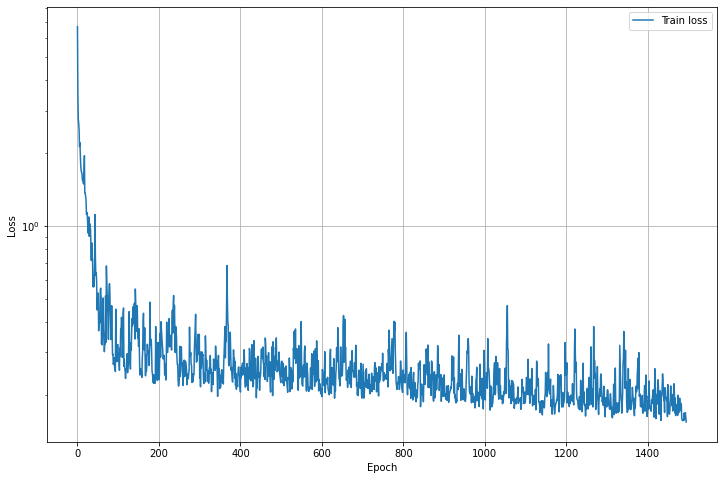

In [ ]:
#######
#Plot of the evolution of the training error
#######

plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# **Testing**

Set 'use_pre' equal to True in the next cell to load a pretrained network.


In [ ]:
#Load a previus trained network
use_pre = False

if use_pre:
  net = initNet() 
  # Load the state dict previously saved
  net_state_dict = torch.load('Regression.torch')
  # Update the network parameters
  net.load_state_dict(net_state_dict)

Network initialized


In [ ]:
#######
#Testing of the Model on Test Dataset
#######

test_dataloader = DataLoader(test_dataset.__getitem__(range(len(test_dataset))), batch_size=len(test_dataset), shuffle=False, num_workers=0)

val_loss= []
net.eval() #evaluation
with torch.no_grad(): #disable gradient tracking
  for sample_batched in test_dataloader:
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    out = net(x_batch) #output of the network

    loss = loss_fn(out, label_batch) #test error

    loss_batch = loss.detach().cpu().numpy()
    val_loss.append(loss_batch)

  val_loss = np.mean(val_loss) #mean of the loss of the batches
  print(f"AVERAGE TEST LOSS: {np.mean(val_loss)}")

AVERAGE TEST LOSS: 0.0804143100976944


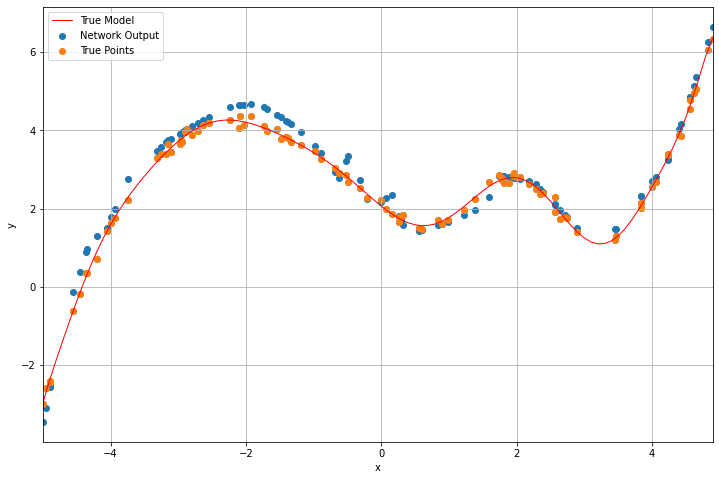

In [ ]:
x_vec = np.array([x[0] for x in test_dataset.data]) #test input data
y_vec = out.squeeze().cpu().numpy() #opredicted labels
testLabel = np.array([pair[1] for pair in test_dataset.data]) #true labels

plt.figure(figsize=(12,8))
ax = sns.regplot(x = x_vec, y = testLabel, line_kws={"color": "red", "linewidth" : 1, "label" : "True Model"}, order=14, ci=None)
plt.scatter(x_vec, y_vec, label='Network Output')
plt.scatter(x_vec, testLabel, label='True Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

# **Weights**

In [ ]:
#First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()

# Third hidden layer
h3_w = net.fc3.weight.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()

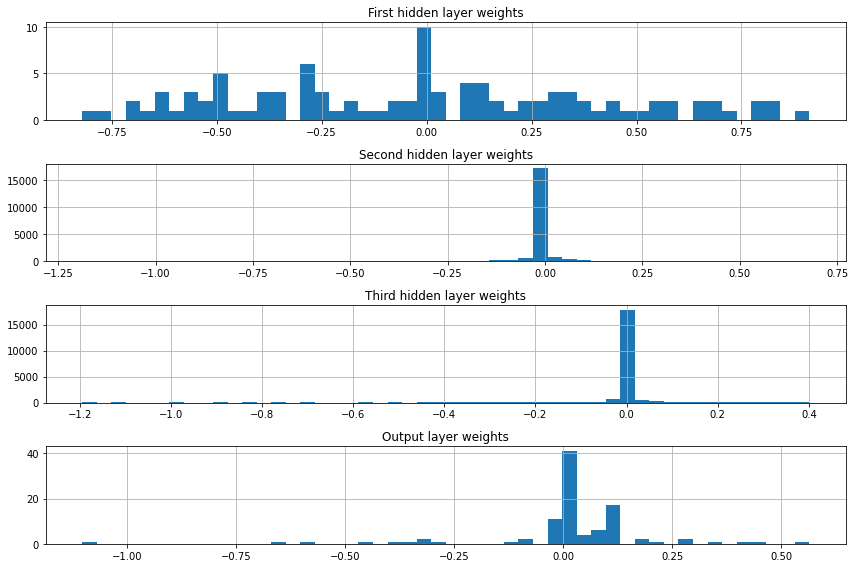

In [ ]:
#######
#Plotting of the Weights Histograms
########

fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third hidden layer weights')
axs[3].hist(out_w.flatten(), 50)
axs[3].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

# **Activations**

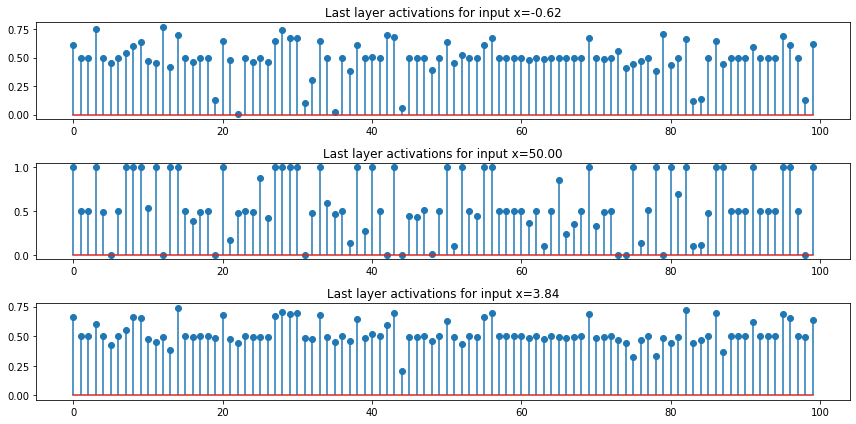

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

#register hook 
hook_handle = net.fc3.register_forward_hook(get_activation)
# net.fc2.register_forward_hook(get_activation)
# net.fc1.register_forward_hook(get_activation)

#rnalyze activations
net = net.to(device)
net.eval()

with torch.no_grad():
    x1 = torch.tensor([test_dataset.data[0][0]]).float().to(device) #first element of the test dataset
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([50]).float().to(device) #element not in the test dataset
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([test_dataset.data[-1][0]]).float().to(device) #last element of the test dataset
    y3 = net(x3)
    z3 = activation

#remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()